## Quantifying Political Polarization
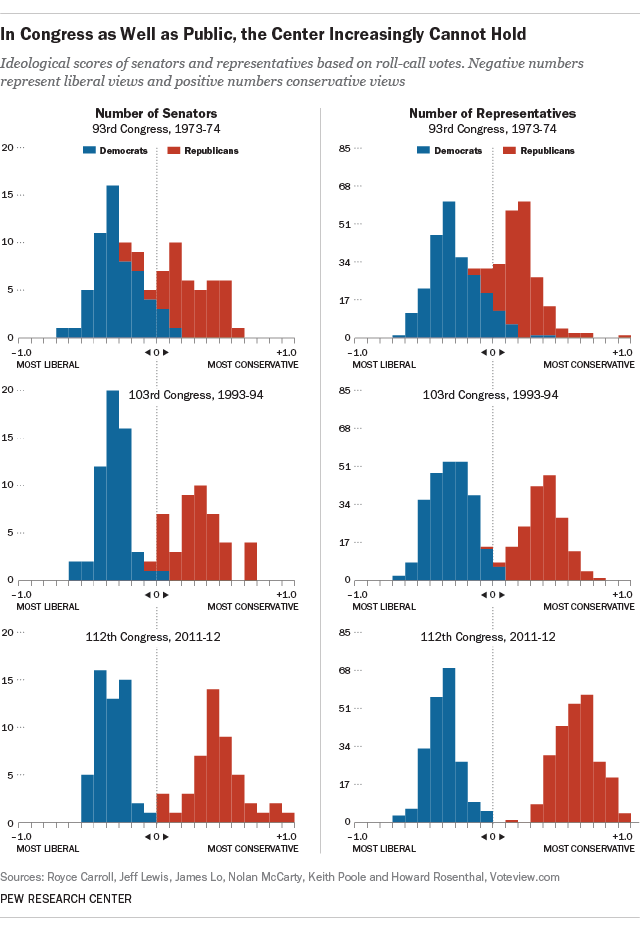
This project will focus on the specific question: Has US Senate voting become more polarized across time? To determine this, we will use a data set containing votes of each member in csv files of each 2 year interval of the Senate. Our main data science tool will be the use of clustering algorithms and a visual comparison using scatter plots of yea/nay votes of each Senate as well as a principal component analysis of the more detailed voting patterns.

The overall goal is to try and learn something about the trend in voting patterns in the Senate over time. This notebook will outline a specific way of performing the analysis, but you are welcome to extend the analysis a number of ways, include those described at the end of the notebook. The specific data you will deal with will be the yea/nay/abstain voting choices of senators on each bill voted on during a 2 year session. Clustering will not simply divide senators based on their total yea/nay vote count, but rather based on how often they tend to vote with other members of the senate.

We will begin by having you load in the csv file S116_votes.csv as a dataframe and print out the head of the data frame:

In [1]:
import pandas as pd

S116 = pd.read_csv('senatecsv/S116_votes.csv')

S116.head()

,congress,chamber,rollnumber,icpsr,cast_code,prob
0,116,Senate,1,14226,1,97.3
1,116,Senate,1,14307,6,97.9
2,116,Senate,1,14435,6,99.9
3,116,Senate,1,14852,1,97.9
4,116,Senate,1,14858,6,99.1


You will notice that the data is in **long form**, so that each row is a different senator vote per congress: the congress (116) in the first column; the chamber (Senate) along the second column; the roll number (this is the vote number) along the third; icpsr is an identifier for each member in the fourth column; cast code is 1 if yea, 6 is nay, and 9 if abstained; and prob is an estimated probability of that vote based on a model generated by the researchers running the voteview website. See the website here for more details on this data set:
https://voteview.com/articles/data_help_votes

Note, there are other versions of yeas that could appear which are 2 and 3, other versions of nays which could appear are 4 and 5, and if there are 7 and 8, then we'll count these as abstains.

Recall here is the distinction between wide and long/narrow form data:
https://en.wikipedia.org/wiki/Wide_and_narrow_data

Now, we'd like to clean the data up a bit, so that we can much more clearly represent the voting trends of different members. To do so, create a pivot table called 'S116_piv' with the values being the case_code, the index being the icpsr, and the columns being the rollnumber (or vote). After you make the pivot table, flatten it to get rid of the extra header using the command *S116_tab=pd.DataFrame(S116_piv.to_records())*.

In [2]:
S116_piv = pd.pivot_table(S116, values='cast_code', index='icpsr',columns='rollnumber')
S116_tab = pd.DataFrame(S116_piv.to_records())
S116_tab

,icpsr,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
0,14226,1.0,1.0,1.0,1.0,6.0,6.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,14307,6.0,6.0,6.0,6.0,1.0,1.0,6.0,1.0,6.0,...,1.0,1.0,6.0,6.0,6.0,6.0,1.0,1.0,1.0,1.0
2,14435,6.0,6.0,6.0,6.0,1.0,1.0,6.0,1.0,6.0,...,6.0,6.0,6.0,6.0,6.0,6.0,1.0,6.0,6.0,6.0
3,14852,1.0,1.0,1.0,1.0,6.0,6.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,14858,6.0,6.0,6.0,6.0,1.0,1.0,6.0,1.0,6.0,...,1.0,1.0,6.0,6.0,6.0,6.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,49300,6.0,6.0,6.0,6.0,1.0,1.0,6.0,1.0,6.0,...,1.0,9.0,6.0,6.0,6.0,6.0,1.0,1.0,1.0,1.0
98,49308,6.0,6.0,6.0,6.0,1.0,1.0,6.0,1.0,6.0,...,1.0,1.0,6.0,6.0,6.0,6.0,1.0,1.0,1.0,1.0
99,49703,1.0,1.0,1.0,6.0,1.0,1.0,6.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
100,49706,1.0,1.0,1.0,1.0,6.0,6.0,1.0,6.0,1.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,1.0,1.0,1.0


You should see that there are 102 rows and 721 columns. This is because two senators were replaced during the 116th congress (from 2019 to 2021) -- one in Arizona and the other in Georgia.

Now, just to get some consistency with the data we worked with in Module 4 on clustering, let's switch to a 1=yea, 0.5=abstain, and 0=nay convention. We'll use the replace functions, so that any 1, 2, or 3 will become a 1; any 4,5,6 will become a 0; any 7,8,9 will become a 0.5. We will list the way to do this for yeas below, you will need to write two more lines, one each for the nay and abstain replacement.

In [3]:
S116_tab=S116_tab.replace([1, 2, 3], 1)
S116_tab=S116_tab.replace([4,5,6], 0)
S116_tab=S116_tab.replace([7, 8, 9.0], 0.5)
S116_tab.head()

,icpsr,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
0,14226,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,14307,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,14435,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,14852,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,14858,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


Before we move on, let's count the number of NaN entries using the *.isna().sum().sum()* extension on the dataframe you have created.

In [4]:
S116_tab.isna().sum().sum()

1440

Noticeably there are quite a few NaN entries, which will disrupt our model fitting. However, it is possible to clean the data to avoid this. We could do this a number of ways. One way would simply be to drop all the columns that have NaNs. Let's do this, using the *.fillna(0.5)* function so that an NaN is treated like an abstention.

In [5]:
S116_tab = S116_tab.fillna(0.5)
S116_tab.head()

,icpsr,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
0,14226,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,14307,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,14435,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,14852,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,14858,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


Now check again how many NaN values there are.

In [6]:
S116_tab.isna().sum().sum()

0

Now we're primarily interested in the yea/nay comparison, so let's get a sense of how many 1's and 6's there are in each row.

To do this, use the count_nonzero function from numpy (np.count_nonzero).
https://numpy.org/doc/stable/reference/generated/numpy.count_nonzero.html
Create a new version of the table, 'S116_tab_yn' and assign a new column of the dataframe titled 'yeas' to the output of the function with the first argument being 'S116_tab==1' and the second argument specifying the axis to search along 'axis=1'. Show the updated dataframe S116_tab_yn afterward.

In [7]:
import numpy as np

S116_tab_yn = S116_tab.copy(deep=True)
S116_tab_yn['yeas']=np.count_nonzero(S116_tab == 1, axis=1)
S116_tab_yn

,icpsr,1,2,3,4,5,6,7,8,9,...,712,713,714,715,716,717,718,719,720,yeas
0,14226,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,640
1,14307,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,359
2,14435,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,149
3,14852,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,620
4,14858,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,49300,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,372
98,49308,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,270
99,49703,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,652
100,49706,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0,602


Now add a column called 'nays' that enumerates the nays in each row (0's) and 'abs' that enumerates the abstentions in each row.

In [8]:
S116_tab_yn['nays']=np.count_nonzero(S116_tab_yn == 0, axis=1)
S116_tab_yn['abs']=np.count_nonzero(S116_tab_yn == 0.5, axis=1)
S116_tab_yn

,icpsr,1,2,3,4,5,6,7,8,9,...,714,715,716,717,718,719,720,yeas,nays,abs
0,14226,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,640,70,10
1,14307,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,359,337,24
2,14435,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,149,492,79
3,14852,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,620,64,36
4,14858,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,255,464,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,49300,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,372,338,10
98,49308,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,270,410,40
99,49703,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,652,68,0
100,49706,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.5,0.5,0.5,0.5,1.0,1.0,1.0,602,88,30


Now, with each of these columns in hand, create a labeled scatter plot where each senator is a data point whose yea count is along the x-axis and nay count is along the y-axis.

Text(0, 0.5, 'Nays')

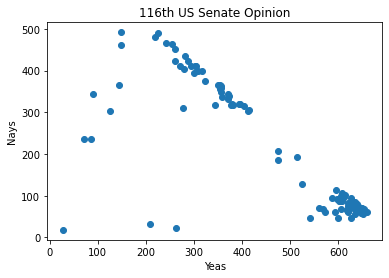

In [9]:
import matplotlib.pyplot as plt

# create a scatter plot
plt.scatter(S116_tab_yn['yeas'], S116_tab_yn['nays'])
# set a title and labels
plt.title('116th US Senate Opinion')
plt.xlabel('Yeas')
plt.ylabel('Nays')

You should see now that there is some vague separation into factions, where one group votes yes very often and another group is distributed across saying yes about half the time or less. We will now use clustering to see how statistically these groups can be distinguished.

Alternatively, you can also represent the first two principal components of the voting data, to get a more detailed description of where each senator lies in the space of voting. You can consult back on Modules 3 and 4 in order to do this.

In [10]:
from sklearn.decomposition import PCA

# use the PCA method and extract two directions from the data
pca_2 = PCA(2)

# now turn the vote data into two columns using PCA
S116_num = S116_tab.drop(['icpsr'], axis=1)
S116_pca_col = pca_2.fit_transform(S116_num)

Now plot the first two principal components.

(array([-6., -4., -2.,  0.,  2.,  4.,  6.,  8., 10.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

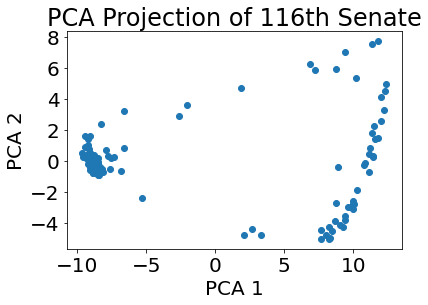

In [11]:
plt.scatter(S116_pca_col[:,0], S116_pca_col[:,1])
# set a title and labels
plt.title('PCA Projection of 116th Senate', fontsize=24)
plt.xlabel('PCA 1', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('PCA 2',fontsize=20)
plt.yticks(fontsize=20)

Do you see a clear clustering along the first two principal components? Would you have expected that based on what we saw in the yea/nay plots?

Yes, it looks like the primary clustering is along the first principal component. We would not necessarily expect this just based on the yea/nay plots because senators may not always vote yea and nay on the same things.

Now perform a K-means two cluster model on the data. Don't forget to make a new dataframe where you remove the icpsr column.

In [12]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
S116_raw = S116_tab.iloc[:, 1:]
model.fit(S116_raw)

KMeans(n_clusters=2)

Now put together the PCA scatter with the labels generated from clustering. Plot a scatter plot of the first two principal components with each data point color labeled by its cluster identity.

(array([-6., -4., -2.,  0.,  2.,  4.,  6.,  8., 10.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

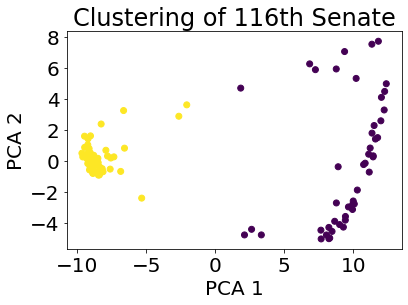

In [13]:
plt.scatter(S116_pca_col[:,0], S116_pca_col[:,1], c=model.labels_)

plt.title('Clustering of 116th Senate', fontsize=24)
plt.xlabel('PCA 1', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('PCA 2',fontsize=20)
plt.yticks(fontsize=20)

What do you find? Is it true that the first two principal components do a good job of separating the clusters or is there structure beyond that is not captured? If not, it may be that you did not remove the dependence on the senator ID number.

Indeed, we find that the clusters are well separated by the first two principal components.

Now try plotting the yea/nay data along with the color cluster labels to see if that reasonably separates the two clusters.

Text(0, 0.5, 'Nays')

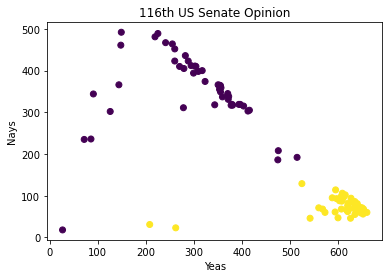

In [14]:
# create a scatter plot
plt.scatter(S116_tab_yn['yeas'], S116_tab_yn['nays'], c = model.labels_)
# set a title and labels
plt.title('116th US Senate Opinion')
plt.xlabel('Yeas')
plt.ylabel('Nays')

Again, it seems that the two clusters are well separated just by yea and nay votes. This suggests that the senators that tend to vote yea a lot tend to vote together and that the senators that vote nay more than about 150 times tend to vote together, so Senate voting is reasonably polarized. We can produce a quantitative measure of how well separated the clusters are by computing the silhouette score. Do this by following the examples from Module 4.

In [15]:
from sklearn.metrics import silhouette_score

silh_score_116 = silhouette_score(S116_raw, model.labels_, metric='euclidean')
print(silh_score_116)

0.5399789151625273


The silhouette score is about 0.54, suggesting that cluster membership is fairly well identified.

Make sure that you have the silhouette score saved as a variable that will not be overwritten.

Now, repeat the above analysis, but for the oldest data set we have on the Senate, S087_votes.csv. Comment on what you see when you create the scatter plots and separate the data into two clusters. Make sure and compute the silhouette score for the clustering and compare it to that obtained for the 116th Senate.

In [16]:
S87 = pd.read_csv('senatecsv/S087_votes.csv')

S87_piv = pd.pivot_table(S87, values='cast_code', index='icpsr',columns='rollnumber')
S87_tab = pd.DataFrame(S87_piv.to_records())

S87_tab=S87_tab.replace([1, 2, 3], 1)
S87_tab=S87_tab.replace([4,5,6], 0)
S87_tab=S87_tab.replace([7, 8, 9.0], 0.5)

S87_tab = S87_tab.fillna(0.5)

S87_tab_yn = S87_tab.copy(deep=True)
S87_tab_yn['yeas']=np.count_nonzero(S87_tab == 1, axis=1)
S87_tab_yn['nays']=np.count_nonzero(S87_tab_yn == 0, axis=1)
S87_tab_yn['abs']=np.count_nonzero(S87_tab_yn == 0.5, axis=1)

Text(0, 0.5, 'Nays')

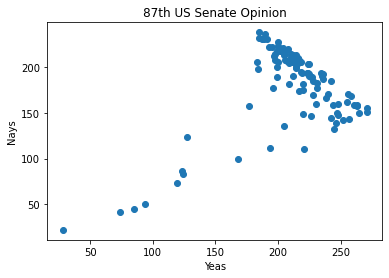

In [17]:
# create a scatter plot
plt.scatter(S87_tab_yn['yeas'], S87_tab_yn['nays'])
# set a title and labels
plt.title('87th US Senate Opinion')
plt.xlabel('Yeas')
plt.ylabel('Nays')

Immediately, we see there is no particular separation into two equal sized groups. Rather there is a continuum of yea and nay voting. This is a rather different picture than that shown in the 116th Senate.

For comparison now, let's see how a scatter plot of the first two PCs looks.

(array([-8., -6., -4., -2.,  0.,  2.,  4.,  6.,  8.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

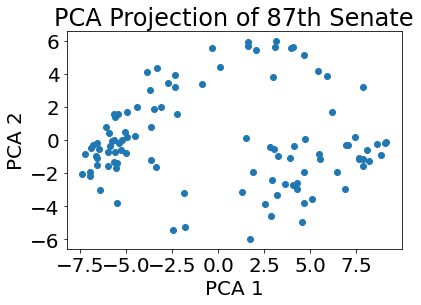

In [18]:
# now turn the vote data into two columns using PCA
S87_num = S87_tab.drop(['icpsr'], axis=1)
S87_pca_col = pca_2.fit_transform(S87_num)

plt.scatter(S87_pca_col[:,0], S87_pca_col[:,1])
# set a title and labels
plt.title('PCA Projection of 87th Senate', fontsize=24)
plt.xlabel('PCA 1', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('PCA 2',fontsize=20)
plt.yticks(fontsize=20)

We do see here now there is a bit more separation when we plot with respect to the first two PCs. Let's see how clustering handles the data set now.

(array([-8., -6., -4., -2.,  0.,  2.,  4.,  6.,  8.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

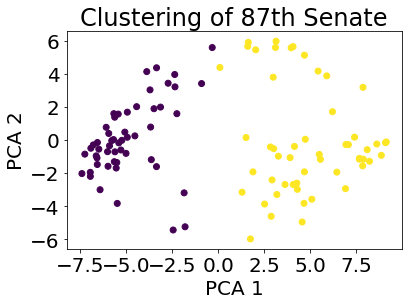

In [19]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
S87_raw = S87_tab.iloc[:, 1:]
model.fit(S87_raw)

plt.scatter(S87_pca_col[:,0], S87_pca_col[:,1], c=model.labels_)

plt.title('Clustering of 87th Senate', fontsize=24)
plt.xlabel('PCA 1', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('PCA 2',fontsize=20)
plt.yticks(fontsize=20)

Indeed we see that clustering nicely separates the data points primarily along the 1st PC, but it is not quite as cleanly separated as in the previous data set. Let's compare this to what we find when plotting cluster identity for the yea/nay split.

Text(0, 0.5, 'Nays')

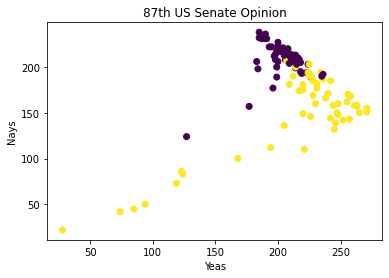

In [20]:
# create a scatter plot
plt.scatter(S87_tab_yn['yeas'], S87_tab_yn['nays'], c = model.labels_)
# set a title and labels
plt.title('87th US Senate Opinion')
plt.xlabel('Yeas')
plt.ylabel('Nays')

The two clusters are rather tightly squished together, different from how we found the clusters separated for the 116th Senate. Let's now conclude by computing the silhouette score.

In [21]:
from sklearn.metrics import silhouette_score

silh_score_87 = silhouette_score(S87_raw, model.labels_, metric='euclidean')
print(silh_score_87)

0.26723758725363717


Indeed, as expected the silhouette score is much lower.

Now having analyzed the earliest (87th) and latest (116th) Senate in our data set. Write a for loop that cleans and computes the silhouette scores for all the data sets in the folder senatecsv. Note, each file has the name SXXX_votes.csv where XXX is a three digit number from 087 to 116. Therefore, you should make a list of the numbers as strings ['087', '088', '089', ..., '115', '116'] and loop through them, reading 'senatecsv/S'+filenum+'_votes.csv'. You will also want to make a list to which you append the silhouette scores from each data set and plot them across time.

In [22]:
filenum = ['087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116']

In [23]:
silh_scores = []

for file_ in filenum:
    Scurr = pd.read_csv('senatecsv/S'+file_+'_votes.csv')

    Scurr_piv = pd.pivot_table(Scurr, values='cast_code', index='icpsr',columns='rollnumber')
    Scurr_tab = pd.DataFrame(Scurr_piv.to_records())

    Scurr_tab=Scurr_tab.replace([1, 2, 3], 1)
    Scurr_tab=Scurr_tab.replace([4,5,6], 0)
    Scurr_tab=Scurr_tab.replace([7, 8, 9.0], 0.5)

    Scurr_tab = Scurr_tab.fillna(0.5)
    
    model = KMeans(n_clusters=2)
    Scurr_raw = Scurr_tab.iloc[:, 1:]
    model.fit(Scurr_raw)
    
    silh_score_curr = silhouette_score(Scurr_raw, model.labels_, metric='euclidean')
    silh_scores.append(silh_score_curr)
    
print(silh_scores)

[0.26723758725363717, 0.2379532695523013, 0.24962188262707932, 0.17447465343065688, 0.20162052784678092, 0.20221231413266808, 0.21046011155633917, 0.22741187821090691, 0.18665289328097273, 0.1942819684631465, 0.2414411442399395, 0.19359724373869683, 0.23291318103506858, 0.2721228409765084, 0.25885097623355574, 0.2868167876249168, 0.3716141728121156, 0.4263924852361499, 0.4098220778590399, 0.4710215126494419, 0.4191738612374349, 0.537923690812452, 0.45579643765602995, 0.4150656614630311, 0.4711432088038699, 0.4504692832016761, 0.5488098308327372, 0.5106053731225405, 0.5390402058080849, 0.5399789151625273]


(array([0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

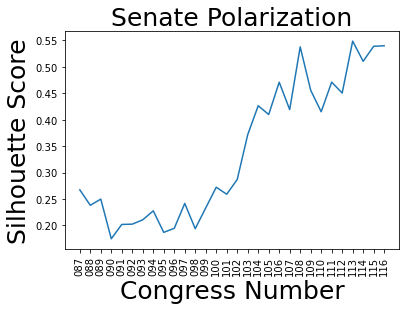

In [24]:
plt.plot(filenum, silh_scores)
plt.title('Senate Polarization',fontsize=25)
plt.xlabel('Congress Number',fontsize=25)
plt.xticks(fontsize=10,rotation=90)
plt.ylabel('Silhouette Score',fontsize=25)
plt.yticks(fontsize=10)

Around the 101st Congress (1989 to 1991), there was a strong increase the the level of polarization. We conclude that there was a systematic increase in the level of polarization over time.

Now, given the preceding analysis, note that we could extend this to House data, or we could look more closely at the specific individuals in each polarized group for each of the Senate data set, or we could look even further across a longer timeframe. If you have time remaining, consider proceeding with one of the following extensions.

**1.** Extend this analysis to the House data contained in the folder housecsv. The voting data takes the same form as the Senate data we analyzed above.

**2.** Look closely at two to three different congressional sessions and the scatter plots of yeas/nays and PCs along with cluster labels. Use HSall_members.csv along with each member's icpsr to add a column to the loaded data frames each for Senators' names and political parties. Then use crosstabs in order to determine if the grouping into clusters is by political party. You could then go further to see if there are any mismatches (some Senators that do not seem to fall into the party based polarized groups) if this makes sense based on any knowledge you have of those Senators. You could also go further by making a measure of how likely it is that two individuals of the same political party are in the same cluster, and you could plot this measure across time, to see again how political party based polarization has evolved over time.

For illustration, here's how you can use the HSall_members.csv file to tack on columns to a data frame including each member's name and political party. Note, we're only doing this for Dems, Reps, or Independent. As you go back in time in the data set though, many other parties will become relevant. Note, if you get Key Errors, you will have to go here and add an entry to the dictionary based on that particular political party.

In [12]:
import pandas as pd

S116 = pd.read_csv('senatecsv/S116_votes.csv')
S116_piv = pd.pivot_table(S116, values='cast_code', index='icpsr',columns='rollnumber')
S116_tab = pd.DataFrame(S116_piv.to_records())
S116_tab.head()

S116_tab=S116_tab.replace([1, 2, 3], 1)
S116_tab=S116_tab.replace([4,5,6], 0)
S116_tab=S116_tab.replace([7, 8, 9.0], 0.5)

S116_tab = S116_tab.fillna(0.5)

members = pd.read_csv('senatecsv/HSall_members.csv')

# first create a column with single letter party indication
party_dict = dict(zip(members.icpsr,members.party_code))
S116_tab.insert(1,'party', S116_tab['icpsr'].map(party_dict), True)
party_num = {100: 'D',
200: 'R', 
328: 'I'}
S116_tab['party'] = S116_tab.party.replace(party_num)

# now pull out the names of each senator and place that in a new column
name_dict = dict(zip(members.icpsr,members.bioname))
S116_tab.insert(2,'name', S116_tab['icpsr'].map(name_dict),True)
S116_tab

,icpsr,party,name,1,2,3,4,5,6,7,...,711,712,713,714,715,716,717,718,719,720
0,14226,R,"GRASSLEY, Charles Ernest",1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,14307,D,"LEAHY, Patrick Joseph",0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,14435,D,"MARKEY, Edward John",0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,14852,R,"ROBERTS, Charles Patrick (Pat)",1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,14858,D,"SCHUMER, Charles Ellis (Chuck)",0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,49300,D,"FEINSTEIN, Dianne",0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
98,49308,D,"MURRAY, Patty",0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
99,49703,R,"COLLINS, Susan Margaret",1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
100,49706,R,"ENZI, Michael B.",1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,1.0,1.0


This is then an example of us running our crosstab based analysis of party polarization on the 116th Senate.

In [13]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
S116_raw = S116_tab.iloc[:, 3:]
model.fit(S116_raw)

print(pd.crosstab(model.labels_, S116_tab['party']))

party   D  I   R
row_0           
0      46  2   0
1       0  0  54


And indeed we see the parties are perfectly polarized in terms of voting along party lines. Try this now for some of the older data sets, and generate a measure that indicates how separated the parties are (we'd say here the parties are 100 percent separated, I'd think).

**3.** Lastly, you could go to the website https://voteview.com/data and download data in CSV format of Data Type: Members' Votes, Chamber: Senate, and Congress which are before the 87th to see if the Senates were even less clustered as we go further back in time.

**4.** Use regression to fit either the silhouette scores across time for the above analysis or other analysis or other quantitative measures that you might generate from looking more closely at parties. You could see how silhouette scores are trending over time with regression models of varying complexity.

**5.** Or consider your own alternative analysis of the Senate data or other versions of the data obtained from voteview.

**6.** Consider a similar analysis of congressional/parliamentary voting from other countries across time. For instance, Canadian parliament lists vote results here: https://www.ourcommons.ca/members/en/votes